In [120]:
from scaling_utils import m
from eqsolver import get_matrix_higher_order,fix_matrix, get_matrix
from grid import get_grid, normalize, convert_to_dict
from scaling_utils import trim, get_normal, get_mask

import numpy as np
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
import palettable as pl
emr = pl.cartocolors.sequential.Emrld_7.get_mpl_colormap()
plt.style.use("Solarize_Light2")
from numba import jit

ImportError: cannot import name 'get_mask' from 'scaling_utils' (C:\Users\KarlKristian\Projects\NumFys\Assignment 1\scaling_utils.py)

In [28]:
g, p = (3, 1)
max_idx =m(g, p)
print(max_idx)
A = get_matrix_higher_order(max_idx)
B = get_matrix(max_idx)

212
44944
(44944,)
(44944,) (44943,) (44942,)
(44944, 44944)
44944
(44944,)
(44944,)
(44944, 44944)


In [119]:
c= np.load(f"solutions/classifications/{g}_{p}.npy")
point_list = get_grid(g, p)
normalize(point_list)
bd = convert_to_dict(point_list)

In [30]:
@jit(nopython=False, forceobj=True)
def fix_matrix_naive(matrix, N_max, boundary_dict=None, contains=None):
    """
    param matrix: Matrix to be "fixed"
    param boundary_dict: Dictionary of boundary points. 
    contains: array of truth values evaluating if a given point is inside or outside the fractal. Precalculated
    """

    if boundary_dict is None:
        boundary_dict = {}
    all_points = [(i, j) for i in range(N_max) for j in range(N_max)]
    # print(len(all_points))

    for idx in range(len(all_points)):
        i, j = all_points[idx]
        if boundary_dict.get(tuple((i, j)), False) or (not contains[i, j]):
            k = i * N_max + j
            matrix[k,:]=0
            matrix[:,k]=0

In [31]:
%time fix_matrix_naive(A, max_idx, bd, c)

Wall time: 3min 55s


In [32]:
%time fix_matrix_naive(B, max_idx, bd, c)

Wall time: 2min 53s


In [33]:
e1, v1 = spl.eigs(A, which='SI', k=20)

In [35]:
%time e2, v2 = spl.eigs(B, which='SI', k = 20)

Wall time: 1min 43s


In [42]:
args = np.argsort(e1/e1[0])
tmp = (e1/e1[0])[args]
E1 = tmp[tmp>=0.999]

In [49]:
E2 = trim(get_normal(e2))

C:\Users\KarlKristian\Projects\NumFys\Assignment 1\scaling_utils.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  return (e/e0).astype(np.float)


In [85]:
testest = (v1[:,args])[:,tmp>=0.99]

In [72]:
V1 = v1[:,tmp>=0.99]

---

In [94]:
def get_mask(arr, c):
    sh = c.shape
    tmp = np.ma.array(arr.reshape(sh), mask=np.invert(c))
    return tmp

In [220]:
sort1 = np.argsort((e1/e1[0])[:6])
sort2 = np.argsort((e2/e2[0])[:6])

In [221]:
plot_list= [*point_list , point_list[0]]

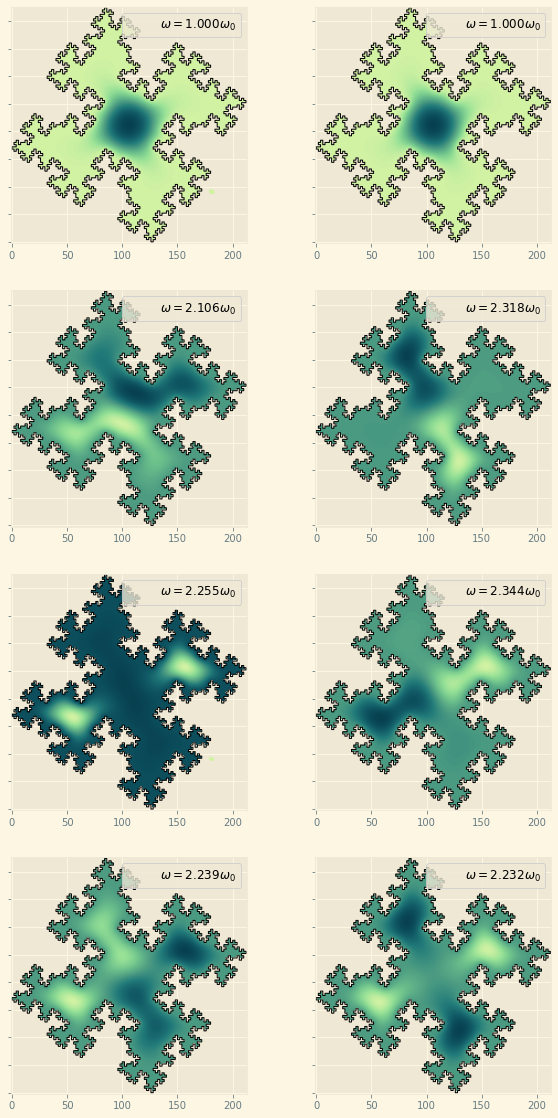

In [228]:
fig, ax = plt.subplots(nrows=4, ncols = 2, figsize =(10, 20))

for i in range(4):
    mask1 = get_mask((v1[:,sort1])[:,i], c)
    mask2 = get_mask((v2[:,sort2])[:,i], c)
    ax[i][0].contourf(mask1.T, cmap=emr, levels = 100)
    ax[i][0].legend([r"$\omega = {:.3f}\omega_0$".format(np.real(e1[i]/e1[0]))],fontsize = 12, loc='best')
    ax[i][0].plot(*zip(*plot_list), 'k',lw=1,)
    ax[i][0].set(aspect='equal')
    ax[i][0].set_yticklabels([])
    ax[i][0].set_ylim(-1,max_idx+1)
    ax[i][0].set_xlim(-1,max_idx+1)
    
    ax[i][1].contourf(mask2.T, cmap=emr, levels= 100)
    ax[i][1].legend([r"$\omega = {:.3f}\omega_0$".format(np.real(e2[i]/e2[0]))],fontsize = 12)
    ax[i][1].plot(*zip(*plot_list), 'k',lw=1,)
    ax[i][1].set_yticklabels([])
    ax[i][1].set_ylim(-1,max_idx+1)
    ax[i][1].set_xlim(-1,max_idx+1)
    

    
    ax[i][1].set(aspect='equal')

In [239]:
eig2 = np.sort((e2/e2[0]))[4:]

In [240]:
eig1 = np.sort((e1/e1[0]))[5:]

Text(0, 0.5, '$\\omega/\\omega_0$')

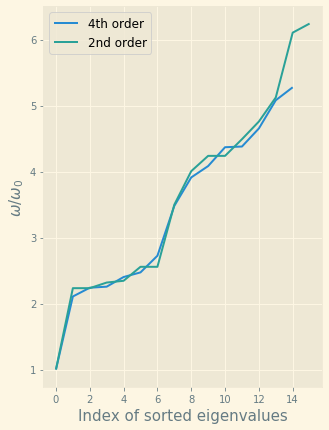

In [252]:
plt.figure(figsize=(5, 7))
plt.plot(eig1, label = "4th order")
plt.plot(eig2, label = "2nd order")
plt.legend(fontsize=12)
plt.xlabel("Index of sorted eigenvalues", size=15)
plt.ylabel(r"$\omega/\omega_0$", size=15)